<a href="https://colab.research.google.com/github/saugatbh/RainfallDataAnalysis/blob/main/ComparisonRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pdb

import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error

In [2]:
data = np.load('/content/drive/MyDrive/rainfall_data.npy')
print(data.shape)

(115, 12, 129, 135)


In [3]:
jan = data[:,0,:,:]#using only Jan data

In [3]:
sel_loc = (64, 74)
loc_data = data[:, :, sel_loc[0], sel_loc[1]].ravel()#using all months data for next one month prediction
#loc_data = jan[:,sel_loc[0], sel_loc[1]].ravel()
loc_data = loc_data[:, None]
print(loc_data.shape)

(1380, 1)


In [4]:
n = loc_data.size
train_data = loc_data[0:int(n*0.7)]
val_data = loc_data[int(n*0.7):int(n*0.9)]
test_data = loc_data[int(n*0.9):]

In [5]:
train_mean = np.mean(train_data)
train_std = np.std(train_data)

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

In [6]:
# generate windows of data for the model
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_data, val_df=val_data, test_df=test_data):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}'])

In [7]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [8]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [9]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [10]:
def plot(self, model=None, max_subplots=3):
  # pdb.set_trace()
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'Actual Value')
    plt.plot(self.input_indices, inputs[n, :, 0],
             label='Inputs', marker='.', zorder=-10)

    plt.scatter(self.label_indices, labels[n, :, 0],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, 0],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [11]:
# create a model with an LSTM
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    #tf.keras.layers.LSTM(32,stateful=True, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [12]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [22]:
w1_wide = WindowGenerator(input_width=36, label_width=36, shift=1)

In [23]:
print('Input shape:', w1_wide.example[0].shape)
print('Output shape(lstm_model):', lstm_model(w1_wide.example[0]).shape)

Input shape: (32, 36, 1)
Output shape(lstm_model): (32, 36, 1)


In [24]:
history = compile_and_fit(lstm_model, w1_wide)

Epoch 1/20
30/30 [==============================] - 3s 32ms/step - loss: 0.3238 - mean_absolute_error: 0.3435 - val_loss: 0.3160 - val_mean_absolute_error: 0.3526
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.3238 - mean_absolute_error: 0.3407 - val_loss: 0.3164 - val_mean_absolute_error: 0.3514
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.3163 - mean_absolute_error: 0.3414 - val_loss: 0.3064 - val_mean_absolute_error: 0.3455
Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 0.3218 - mean_absolute_error: 0.3405 - val_loss: 0.3131 - val_mean_absolute_error: 0.3504
Epoch 5/20
30/30 [==============================] - 1s 25ms/step - loss: 0.3173 - mean_absolute_error: 0.3379 - val_loss: 0.3102 - val_mean_absolute_error: 0.3453
Epoch 6/20
30/30 [==============================] - 1s 20ms/step - loss: 0.3194 - mean_absolute_error: 0.3412 - val_loss: 0.3084 - val_mean_absolute_error: 0.3482
Epoch 7/20
30/30 [====

In [25]:
print(w1_wide.test)

<MapDataset shapes: ((None, 36, 1), (None, 36, 1)), types: (tf.float32, tf.float32)>


In [27]:
IPython.display.clear_output()
print(lstm_model.evaluate(w1_wide.val))
print(lstm_model.evaluate(w1_wide.test))

8/8 [==============================] - 0s 4ms/step - loss: 0.3200 - mean_absolute_error: 0.3553
[0.3199693262577057, 0.35529622435569763]
4/4 [==============================] - 0s 5ms/step - loss: 0.3133 - mean_absolute_error: 0.3585
[0.3133189380168915, 0.35848256945610046]


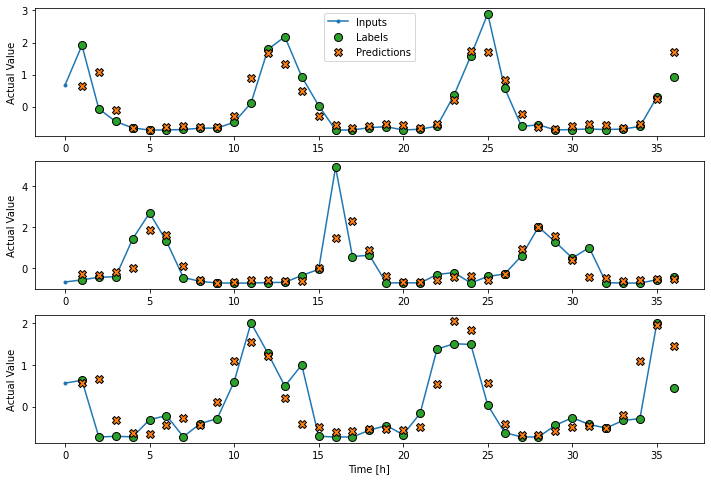

In [28]:
w1_wide.plot(lstm_model)